In [22]:
MODELS_FROM_FILE = 0
IMPORTANCES_FROM_FILE = 0

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)
pd.set_option('display.precision', 2)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")

learning_disorder_cols = [
    "Diag: Specific Learning Disorder with Impairment in Reading",
    "Diag: Specific Learning Disorder with Impairment in Mathematics",
    "Diag: Intellectual Disability-Mild",
    "Diag: Borderline Intellectual Functioning",
    # no writing diagnosis because no writing tasks in HBN
]

diag_cols = {"Math": "New Diag: Specific Learning Disorder with Impairment in Mathematics",
            "Reading": "New Diag: Specific Learning Disorder with Impairment in Reading",
            "Intel Mild": "New Diag: Intellectual Disability-Mild",
            "Intel Bdl": "New Diag: Borderline Intellectual Functioning"}

In [23]:
# Create test-based or consensus diagnosis columns

item_lvl_w_imp[diag_cols["Math"]] = (item_lvl_w_imp["WIAT,WIAT_Num_Stnd"] < 85) | (item_lvl_w_imp["Diag: Specific Learning Disorder with Impairment in Mathematics"] == 1)
item_lvl_w_imp[diag_cols["Reading"]] = (item_lvl_w_imp["WIAT,WIAT_Word_Stnd"] < 85) | (item_lvl_w_imp["Diag: Specific Learning Disorder with Impairment in Reading"] == 1)
item_lvl_w_imp[diag_cols["Intel Mild"]] = (item_lvl_w_imp["WISC,WISC_FSIQ"] < 70) | (item_lvl_w_imp["Diag: Borderline Intellectual Functioning"] == 1)
item_lvl_w_imp[diag_cols["Intel Bdl"]] = ((item_lvl_w_imp["WISC,WISC_FSIQ"] < 85) & (item_lvl_w_imp["WISC,WISC_FSIQ"] > 70)) | (item_lvl_w_imp["Diag: Intellectual Disability-Mild"] == 1)

print(item_lvl_w_imp[diag_cols["Math"]].value_counts())
print(item_lvl_w_imp[diag_cols["Reading"]].value_counts())
print(item_lvl_w_imp[diag_cols["Intel Mild"]].value_counts())
print(item_lvl_w_imp[diag_cols["Intel Bdl"]].value_counts())

False    1446
True      416
Name: New Diag: Specific Learning Disorder with Impairment in Mathematics, dtype: int64
False    1364
True      498
Name: New Diag: Specific Learning Disorder with Impairment in Reading, dtype: int64
False    1809
True       53
Name: New Diag: Intellectual Disability-Mild, dtype: int64
False    1539
True      323
Name: New Diag: Borderline Intellectual Functioning, dtype: int64


In [24]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    svc = svm.SVC()
    lr = LogisticRegression(solver="liblinear")
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svc_pipe = make_pipeline(imputer, scaler, svc)
    lr_pipe = make_pipeline(imputer, scaler, lr)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeclassifier__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeclassifier__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeclassifier__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeclassifier__max_leaf_nodes": np.random.randint(2, 50, 30),
        "decisiontreeclassifier__criterion": ['gini', 'entropy'],
        "decisiontreeclassifier__class_weight": ['balanced', None]
    }
    rf_param_grid = {
        'randomforestclassifier__max_depth' : np.random.randint(5, 150, 30),
        'randomforestclassifier__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestclassifier__n_estimators': np.random.randint(50, 400, 10),
        'randomforestclassifier__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0],
        'randomforestclassifier__criterion': ['gini', 'entropy'],
        'randomforestclassifier__class_weight':["balanced", "balanced_subsample", None],
        "randomforestclassifier__class_weight": ['balanced', None]
    }
    svc_param_grid = {
        'svc__C': loguniform(1e-03, 1e+02),
        'svc__gamma': loguniform(1e-03, 1e+02),
        'svc__degree': uniform(2, 5),
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        "svc__class_weight": ['balanced', None]
    }
    lr_param_grid = {
        'logisticregression__C': loguniform(1e-5, 100),
        'logisticregression__penalty': ['l1', 'l2']
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svc_pipe, svc_param_grid),
        (lr_pipe, lr_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col, X_train, y_train):
    cv = StratifiedKFold(n_splits=3)
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=cv, scoring="roc_auc", n_iter=100, n_jobs = -1)
    
    rs.fit(X_train, y_train) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    # If chosen model is SVM add a predict_proba parameter (not needed for grid search, and slows it down significantly)
    if 'svc' in best_estimator.named_steps.keys():
        best_estimator.set_params(svc__probability=True)

    return (best_estimator, best_score)

In [25]:
def find_best_classifier_for_diag(diag, X_train, y_train):
    best_score = 0
    best_classifier = None
    base_models_and_param_grids = get_base_models_and_param_grids()
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, diag, X_train, y_train)
        if best_score_for_model > best_score:
            best_classifier = best_classifier_for_model
            best_score = best_score_for_model
    return best_classifier

In [41]:
def get_input_and_output_cols_for_diag(diag):
    
    # For each diagnosis, remove corresponding consensus diagnosis from the input columns
    consensus_diag = "Diag: " + diag.split(":")[1]
    print(consensus_diag)
    
    input_cols = [x for x in item_lvl_w_imp.columns if 
                        not x.startswith("WIAT")
                        and not x.startswith("WISC")
                        and not x in ["WHODAS_P,WHODAS_P_Total", "CIS_P,CIS_P_Score", "WHODAS_SR,WHODAS_SR_Score", "CIS_SR,CIS_SR_Total"]
                        and not x.startswith("New Diag: ")
                        and not x == consensus_diag]
    
    output_col = diag
    
    return input_cols, output_col

In [42]:
# Calculate probability threshold
beta = 3
def calculate_threshold(classifier, X_train_train, y_train_train, X_val, y_val, b = beta):
    from numpy import nanargmax
    
    # Fit model on validation set
    classifier.fit(X_train_train, y_train_train)
    
    # Get predicted probabilities values
    y_val_pred_prob = classifier.predict_proba(X_val)
    
    # Calculate precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_prob[:,1])
    
    # Calculate F-scores
    fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
    
    # Locate the index of the largest F-score
    ix = nanargmax(fscores)
    
    threshold = thresholds[ix]
    
    return threshold

In [43]:
# Find best classifier
if MODELS_FROM_FILE == 0:
    best_classifiers = {}
    for key in diag_cols:
        if key == "Math": #DEBUG, REMOVE CONDITION
            diag = diag_cols[key]

            print(diag)

            # Get input and output columns
            input_cols, output_col = get_input_and_output_cols_for_diag(diag)

            # Split train, validation, and test sets
            X_train, X_test, y_train, y_test = train_test_split(item_lvl_w_imp[input_cols], item_lvl_w_imp[output_col], test_size=0.3, random_state=1)
            X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1) 

            if item_lvl_w_imp[diag].sum() > 50: # Don't use diagnoses if there are less than 50 positive examples
                best_classifier_for_diag = find_best_classifier_for_diag(diag, X_train, y_train)
                #threshold = calculate_threshold(best_classifier_for_diag, diag, X_train_train, y_train_train, X_val, y_val, beta)
                best_classifiers[diag] = (best_classifier_for_diag, threshold)
    print(best_classifiers)

New Diag: Specific Learning Disorder with Impairment in Mathematics
Diag:  Specific Learning Disorder with Impairment in Mathematics


/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'New Diag: Specific Learning Disorder with Impairment in Mathematics': (Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=94,
                                        max_features=0.75, min_samples_leaf=4,
                                        min_samples_split=34,
                                        n_estimators=354))]), 1.0)}


In [44]:
# Find best thresholds
def find_best_thresholds(beta=beta):
    best_thresholds = {}
    for diag in best_classifiers:
        if item_lvl_w_imp[diag].sum() > 50: # Don't use diagnoses if there are less than 50 positive examples
            best_classifier_for_diag = best_classifiers[diag][0]
            threshold = calculate_threshold(best_classifier_for_diag, X_train_train, y_train_train, X_val, y_val, beta)
            best_thresholds[diag] = threshold
    print(best_thresholds)
    return best_thresholds

if MODELS_FROM_FILE == 0:
    best_thresholds = find_best_thresholds(beta=beta)

{'New Diag: Specific Learning Disorder with Impairment in Mathematics': 0.16641537162501815}


In [45]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best classifiers and thresholds - best parameters, and the classifyer objects themselves
    best_classifiers_df = pd.DataFrame(best_classifiers).T.reset_index()
    best_classifiers_df.columns = ["Diag", "Best Estimator", "Best Threshold"]
    display(best_classifiers_df)
    best_classifiers_df.to_csv("best-estimators-cons-and-thresh-item-lvl.csv")

    dump(best_classifiers, 'best-classifiers-cons-and-thresh-item-lvl.joblib', compress=1)
    dump(best_thresholds, 'best-thresholds-cons-and-thresh-item-lvl.joblib', compress=1)

Diag  \
0  New Diag: Specific Learning Disorder with Impairment in Mathematics   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [46]:
import math
metric_names = ['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos','check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','F1','FBeta','MCC','BM','MK']   
def get_matrix_metrics(real_values,pred_values,beta):
    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]+0.01 # +0.01 To avoid division by 0 errors
    FN = CM[1][0]+0.01
    TP = CM[1][1]+0.01
    FP = CM[0][1]+0.01
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    #DOR        = round( LRPos/LRNeg)
    DOR        = 1 # FIX, LINE ABOVE
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1   
    
    mat_met = [TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,FBeta,MCC,BM,MK]
    return (mat_met)

In [47]:
def get_metrics(classifier, threshold, X, y, print_output_flag = 0):
       
    y_pred_prob = classifier.predict_proba(X)
    y_pred = (y_pred_prob[:,1] >= threshold).astype(bool) 
    
    roc_auc = roc_auc_score(y, y_pred_prob[:,1])
    
    metrics = get_matrix_metrics(y, y_pred, beta=3)
    metrics.append(roc_auc)
    
    if print_output_flag:
        print(output_col)
        
        # Display confusion matrix
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

        # Display the ROC curve 
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', label='Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        
        display = PrecisionRecallDisplay.from_predictions(y, y_pred_prob[:,1])
        display.ax_.set_title("Precision-Recall curve")
        plt.scatter(metrics[metric_names.index("Recall")], metrics[metric_names.index("Precision")], marker='o', color='black', label='Best')
        plt.show()
        
    return metrics

New Diag: Specific Learning Disorder with Impairment in Mathematics


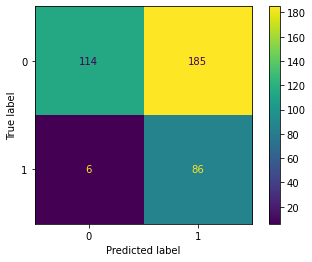

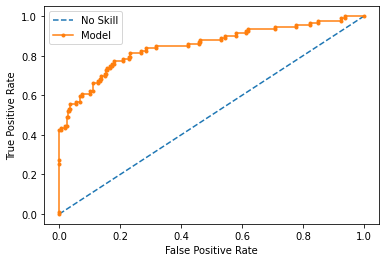

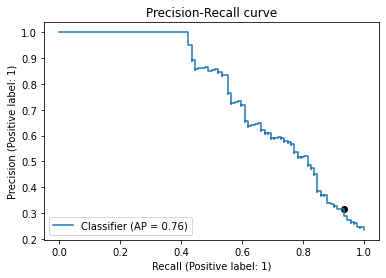

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC
0,New Diag: Specific Learning Disorder with Impairment in Mathematics,86.01,114.01,185.01,6.01,0.69,0.51,0.32,0.95,0.68,0.05,1.0,1.0,0.93,0.62,0.07,0.38,1.0,1.0,1.51,0.17,1,0.47,0.78,0.29,0.32,0.27,0.85


In [48]:
# Check performance of the final model on validation set for all models

results_val_set = []
for diag in best_classifiers:
    
    classifier = best_classifiers[diag][0]
    threshold = best_thresholds[diag]
    metrics = get_metrics(classifier, threshold, X_val, y_val, 1)
    prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
    results_val_set.append([
        diag, 
        *metrics])
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_val_set_df.sort_values(by="ROC AUC", ascending=False)

In [49]:
# Do cross-validation to get more reliable ROC AUC scores (f1 harder to obtain with cross validation - need to change threshold)

auc_cv_mean_val_set = []
auc_cv_std_val_set = []
for diag in best_classifiers:
    
    classifier = best_classifiers[diag][0]

    cv = StratifiedKFold(n_splits=5)
    auc = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

    auc_cv_mean_val_set.append(auc.mean())
    auc_cv_std_val_set.append(auc.std())
restults_val_set_df["ROC AUC Mean CV"] = pd.Series(auc_cv_mean_val_set)
restults_val_set_df["ROC AUC Std CV"] = pd.Series(auc_cv_std_val_set)
restults_val_set_df

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC,ROC AUC Mean CV,ROC AUC Std CV
0,New Diag: Specific Learning Disorder with Impairment in Mathematics,86.01,114.01,185.01,6.01,0.69,0.51,0.32,0.95,0.68,0.05,1.0,1.0,0.93,0.62,0.07,0.38,1.0,1.0,1.51,0.17,1,0.47,0.78,0.29,0.32,0.27,0.85,0.87,0.02


New Diag: Specific Learning Disorder with Impairment in Mathematics


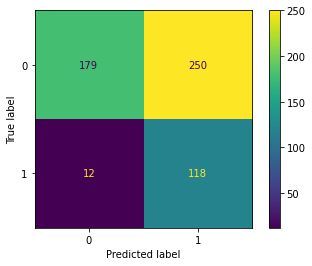

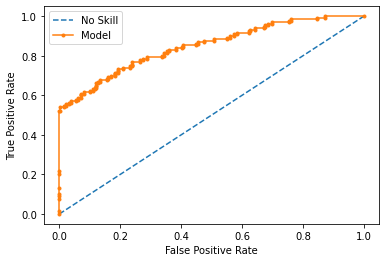

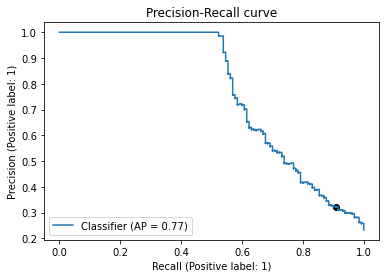

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC
0,New Diag: Specific Learning Disorder with Impairment in Mathematics,118.01,179.01,250.01,12.01,0.66,0.53,0.32,0.94,0.68,0.06,1.0,1.0,0.91,0.58,0.09,0.42,1.0,1.0,1.56,0.22,1,0.47,0.77,0.29,0.32,0.26,0.85


In [50]:
# Check performance of the final model on test set for all models

results_test_set = []
for diag in best_classifiers:
    
    classifier = best_classifiers[diag][0]
    threshold = best_thresholds[diag]
    metrics = get_metrics(classifier, threshold, X_test, y_test, 1)
    prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
    results_test_set.append([
        diag, 
        *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_test_set_df

In [51]:
rf = best_classifiers[diag_cols["Math"]][0]
plt.barh(item_lvl_w_imp.feature_names, rf.feature_importances_)

AttributeError: 'DataFrame' object has no attribute 'feature_names'